Using data from nevena flat line removal

In [108]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
# --- Data Loading ---
directory_path = r'/home/ryan/Documents/CBI/nesscan_fixed_removed_flat_lines_03312025/bobHallPier'
dataframes = []
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory_path, filename)
        df = pd.read_csv(
            file_path,
            parse_dates=[0],
            na_values=[-999, -99, 99, 'NA', 'RM'],
            engine='python'
        )
        df.columns = ['date', 'pwl']
        dataframes.append(df)

bhp = pd.concat(dataframes, ignore_index=True)
bhp['date'] = pd.to_datetime(bhp['date'])
bhp = bhp[bhp['date'] >= pd.to_datetime('1996-01-01')]
bhp = bhp.reset_index(drop=True)

# --- Remove obvious outliers using ±4 from median ---
median_val = bhp['pwl'].median()
bhp.loc[np.abs(bhp['pwl'] - median_val) > 4, 'pwl'] = np.nan


In [109]:

pwl = bhp['pwl']
s = lambda x: pwl.shift(x)

# --- Compute All 8 Third Differences ---
bhp['3DF']    = s(3)  - 3 * s(2)  + 3 * s(1)  - s(0)
bhp['3DFm1']  = s(4)  - 3 * s(3)  + 3 * s(2)  - s(0)
bhp['3DFm2']  = s(4)  - 3 * s(3)  + 3 * s(1)  - s(0)
bhp['3DFm3']  = s(4)  - 3 * s(2)  + 3 * s(1)  - s(0)

bhp['3DB']    = s(-3) - 3 * s(-2) + 3 * s(-1) - s(0)
bhp['3DBm1']  = s(-4) - 3 * s(-3) + 3 * s(-2) - s(0)
bhp['3DBm2']  = s(-4) - 3 * s(-3) + 3 * s(-1) - s(0)
bhp['3DBm3']  = s(-3) - 3 * s(-2) + 3 * s(-1) - s(0)

third_diff_cols = ['3DF', '3DFm1', '3DFm2', '3DFm3', '3DB', '3DBm1', '3DBm2', '3DBm3']
bhp[third_diff_cols] = bhp[third_diff_cols].round(4)


# --- Flag Each 3D if it Exceeds ±6 STD ---
def create_flag_column(col):
    std = bhp[col].std(skipna=True)
    mean = bhp[col].mean(skipna=True)
    upper = mean + 6 * std
    lower = mean - 6 * std
    return ((bhp[col] > upper) | (bhp[col] < lower)).astype(int)

for col in ['3DF', '3DFm1', '3DFm2', '3DFm3', '3DB', '3DBm1', '3DBm2', '3DBm3']:
    bhp[f'{col}_flag'] = create_flag_column(col)

# --- Final Suspect Flag: No 3D values could be calculated
flag_cols = ['3DF', '3DFm1', '3DFm2', '3DFm3', '3DB', '3DBm1', '3DBm2', '3DBm3']
bhp['suspect_flag'] = bhp[flag_cols].isna().all(axis=1).astype(int)

# Optional: mark as NaN in final output
bhp['pwl_cleaned'] = np.where(
    bhp[[f'{c}_flag' for c in flag_cols]].sum(axis=1) > 0,
    np.nan,
    bhp['pwl']
)
bhp.loc[bhp['suspect_flag'] == 1, 'pwl_cleaned'] = np.nan

# --- View Result ---
cols = ['pwl'] + flag_cols + [f'{c}_flag' for c in flag_cols] + ['suspect_flag', 'pwl_cleaned']
print(bhp[cols].head(40))

      pwl    3DF  3DFm1  3DFm2  3DFm3    3DB  3DBm1  3DBm2  3DBm3  3DF_flag  \
0   6.800    NaN    NaN    NaN    NaN -0.066 -0.012 -0.111 -0.066         0   
1   6.773    NaN    NaN    NaN    NaN  0.015 -0.063 -0.144  0.015         0   
2   6.806    NaN    NaN    NaN    NaN -0.096  0.170  0.062 -0.096         0   
3   6.833  0.066    NaN    NaN    NaN  0.143 -0.014  0.139  0.143         0   
4   6.869 -0.015  0.030  0.111  0.012 -0.050 -0.062 -0.077 -0.050         0   
5   6.818  0.096  0.036  0.144  0.063 -0.011  0.019 -0.014 -0.011         0   
6   6.823 -0.143  0.091 -0.062 -0.170  0.014 -0.045 -0.063  0.014         0   
7   6.834  0.050 -0.154 -0.139  0.014 -0.056  0.102  0.057 -0.056         0   
8   6.840  0.011  0.044  0.077  0.062  0.096 -0.032  0.064  0.096         0   
9   6.855 -0.014 -0.004  0.014 -0.019 -0.047 -0.085 -0.136 -0.047         0   
10  6.823  0.056  0.018  0.063  0.045 -0.053  0.090  0.033 -0.053         0   
11  6.840 -0.096  0.039 -0.057 -0.102  0.073  0.025 

In [126]:
# Get all _flag columns except 'suspect_flag'
flag_cols = [col for col in bhp.columns if col.endswith('_flag') and col != 'suspect_flag']
for col in ['spike_pass', 'spike_repeat_flag']:
    if col not in bhp.columns:
        bhp[col] = 0
# Get rows where ANY flag column is set
flagged_rows = bhp[flag_cols].any(axis=1)

# Get indices of those rows
flagged_indices = bhp.index[flagged_rows]

# Loop over each flagged row
for i in flagged_indices:
    spike_val = bhp.at[i, 'pwl']
    pass_val = bhp.at[i, 'spike_pass']

    # If the spike_val is NaN, skip it
    if pd.isna(spike_val):
        continue

    # Check forward for repeated exact matches
    j = i + 1
    while j < len(bhp) and bhp.at[j, 'pwl'] == spike_val:
        if bhp.loc[j, flag_cols].sum() == 0:  # only flag if not already flagged
            bhp.at[j, 'spike_repeat_flag'] = 1
            bhp.at[j, 'spike_flag'] = 1
            bhp.at[j, 'spike_pass'] = pass_val
            bhp.at[j, 'pwl_cleaned'] = np.nan
            bhp.loc[j, flag_cols] = 1  # flag all *_flag columns
        j += 1


Had to change from 5 repeated values after a spike to unlimited values after a spike due to this case of 2.777 6 times

In [110]:
bhp[576620:576670]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,pwl_cleaned
576620,2002-07-30 14:00:00,6.658,0.002,0.015,0.018,0.003,-0.031,-0.046,-0.052,-0.031,0,0,0,0,0,0,0,0,0,6.658
576621,2002-07-30 14:06:00,6.627,0.020,0.033,0.018,0.015,-0.015,0.023,0.011,-0.015,0,0,0,0,0,0,0,0,0,6.627
576622,2002-07-30 14:12:00,6.629,-0.059,0.018,-0.075,-0.060,0.021,-0.008,0.019,0.021,0,0,0,0,0,0,0,0,0,6.629
576623,2002-07-30 14:18:00,6.633,0.031,-0.063,-0.057,0.036,-0.012,0.011,0.014,-0.012,0,0,0,0,0,0,0,0,0,6.633
576624,2002-07-30 14:24:00,6.624,0.015,0.040,0.052,0.046,0.020,-0.021,-0.006,0.020,0,0,0,0,0,0,0,0,0,6.624
576625,2002-07-30 14:30:00,6.623,-0.021,0.016,-0.011,-0.023,-0.020,-0.029,-0.062,-0.020,0,0,0,0,0,0,0,0,0,6.623
576626,2002-07-30 14:36:00,6.618,0.012,-0.016,-0.019,0.008,-0.024,0.076,0.055,-0.024,0,0,0,0,0,0,0,0,0,6.618
576627,2002-07-30 14:42:00,6.629,-0.020,0.001,-0.014,-0.011,0.065,-3.900,-3.837,0.065,0,0,0,0,0,1,1,0,0,NaN
576628,2002-07-30 14:48:00,6.636,0.020,-0.027,0.006,0.021,-3.907,7.703,7.655,-3.907,0,0,0,0,1,1,1,1,0,NaN
576629,2002-07-30 14:54:00,6.615,0.024,0.041,0.062,0.029,7.724,-3.838,7.724,7.724,0,0,0,0,1,1,1,1,0,NaN


In [111]:
bhp['suspect_flag'].sum() - bhp['pwl'].isna().sum()

306

In [128]:
bhp['spike_repeat_flag'].sum()

6

Text(0, 0.5, 'Freq')

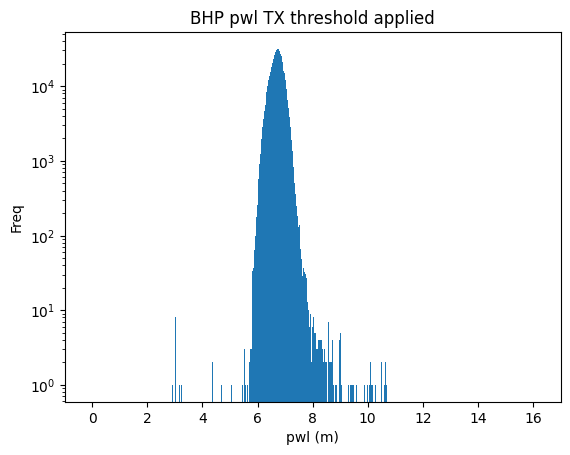

In [112]:
plt.hist(bhp['pwl'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl TX threshold applied')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

Text(0, 0.5, 'Freq')

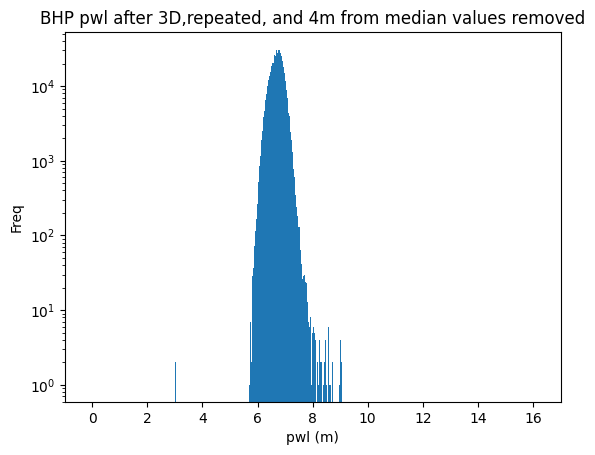

In [113]:
plt.hist(bhp['pwl_cleaned'],1000)
plt.yscale('log')
plt.xlim(-1,17)
plt.title('BHP pwl after 3D,repeated, and 4m from median values removed')
plt.xlabel('pwl (m)')
plt.ylabel('Freq')

In [114]:
bhp['pwl_cleaned'].idxmax()

508246

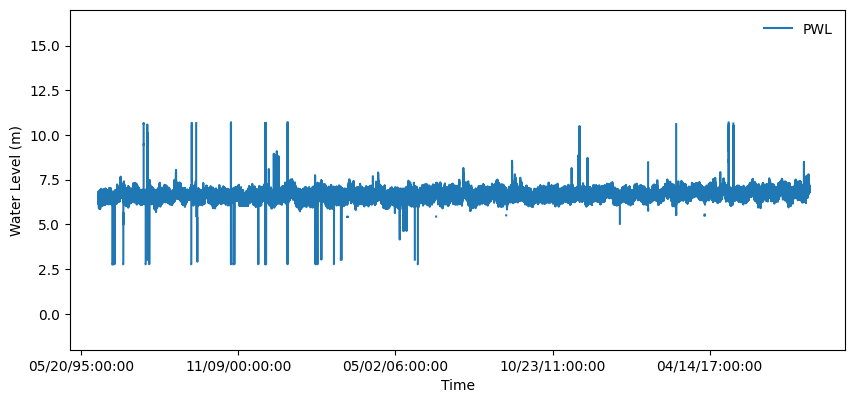

In [115]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2021/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl'], label='PWL')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

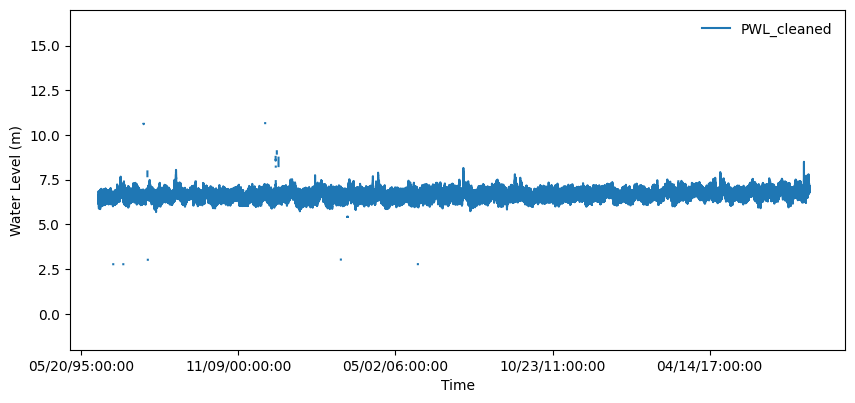

In [116]:
start_date = pd.to_datetime('1995/01/01 00:00')
end_date = pd.to_datetime('2021/12/30 03:30')

# Filter the data to only include the xlim range
filtered_data = bhp[(bhp['date'] >= start_date) & (bhp['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl_cleaned'], label='PWL_cleaned')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D:%H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=2000))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(-2,17)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()

Need to find a way to handle the values after a gap, maybe switching to a forward pass at those locations

In [117]:
bhp[41420:41450]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,pwl_cleaned
41420,1996-06-21 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
41421,1996-06-21 14:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
41422,1996-06-21 14:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
41423,1996-06-21 14:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
41424,1996-06-21 14:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
41425,1996-06-21 14:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
41426,1996-06-21 14:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
41427,1996-06-21 14:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
41428,1996-06-21 14:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
41429,1996-06-21 14:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN


In [118]:
bhp['pwl_cleaned'].isna().sum() - bhp['pwl'].isna().sum()

2374

In [119]:
bhp[44340:44360]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,pwl_cleaned
44340,1996-07-03 18:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
44341,1996-07-03 18:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
44342,1996-07-03 18:12:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
44343,1996-07-03 18:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
44344,1996-07-03 18:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
44345,1996-07-03 18:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
44346,1996-07-03 18:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
44347,1996-07-03 18:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
44348,1996-07-03 18:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
44349,1996-07-03 18:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN


In [120]:
suspects_df = bhp[bhp['suspect_flag'] == 1].copy()


In [121]:
suspects_df = suspects_df.dropna(subset=['pwl'])

In [122]:
suspects_df

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,3DF_flag,3DFm1_flag,3DFm2_flag,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,pwl_cleaned
75053,1996-11-08 17:18:00,5.034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
75054,1996-11-08 17:24:00,5.665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
137226,1997-07-25 18:36:00,9.473,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
148676,1997-09-11 11:36:00,8.158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
148707,1997-09-11 14:42:00,9.299,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2029721,2019-02-26 04:06:00,6.788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
2069780,2019-08-12 02:00:00,6.411,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
2069781,2019-08-12 02:06:00,6.416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN
2069782,2019-08-12 02:12:00,6.416,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,1,NaN


In [127]:
bhp[75043:75073]

,date,pwl,3DF,3DFm1,3DFm2,3DFm3,3DB,3DBm1,3DBm2,3DBm3,...,3DFm3_flag,3DB_flag,3DBm1_flag,3DBm2_flag,3DBm3_flag,suspect_flag,pwl_cleaned,spike_pass,spike_repeat_flag,spike_flag
75043,1996-11-08 16:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,NaN,0,0,NaN
75044,1996-11-08 16:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,NaN,0,0,NaN
75045,1996-11-08 16:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,NaN,0,0,NaN
75046,1996-11-08 16:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,NaN,0,0,NaN
75047,1996-11-08 16:42:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,NaN,0,0,NaN
75048,1996-11-08 16:48:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,NaN,0,0,NaN
75049,1996-11-08 16:54:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,NaN,0,0,NaN
75050,1996-11-08 17:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,NaN,0,0,NaN
75051,1996-11-08 17:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,1,NaN,0,0,NaN
75052,1996-11-08 17:12:00,5.057,NaN,NaN,NaN,NaN,-1.937,NaN,NaN,-1.937,...,0,1,0,0,1,0,NaN,0,0,NaN
